# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

In [1]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-54zzoml0/keras-ocr_70b20ad87f4644ca933c5a562fad80f9
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-54zzoml0/keras-ocr_70b20ad87f4644ca933c5a562fad80f9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.5 MB 6.1 MB/s 
     |████████████████████████████████| 895 kB 5.0 MB/s 
     |████████████████████████████████| 603 kB 34.9 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.9-py3-none-any.whl size=41435 sha256=d8f1b253e2e5d644c48363bae229194f0c05848d9017844b6de50a75b21546c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_zz4rgi/wheels/20/d0/06/ed290995144ec8dde71d3a91d0d590145445c01be60ea70c9b
Successfully built keras-ocr
     |████████████████████████████████| 60.4 MB 1.4 MB/s 
 

This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the "Born Digital" dataset from https://rrc.cvc.uab.es/?ch=1&com=downloads

First, we download our dataset. Below we get both the training and test datasets, but
we only use the training dataset. The training dataset consists of a single folder
containing images, each of which has a single word in it. The labels are in a text
file called `gt.txt`.

In [2]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.test.is_gpu_available()

train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir='.'
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir='.'
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Looking for ./borndigital/Challenge1_Training_Task3_Images_GT.zip
Looking for ./borndigital/Challenge1_Test_Task3_Images.zip
Looking for ./borndigital/test/Challenge1_Test_Task3_GT.txt


We next build our recognizer, using the default options to get a pretrained model.

In [3]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Looking for /root/.keras-ocr/crnn_kurapan.h5


We need to convert our dataset into the format that :code:`keras-ocr` requires. To 
do that, we have the following, which includes support for an augmenter to
generate synthetically altered samples. Note that this code is set up to skip
any characters that are not in the recognizer alphabet and that all labels
are first converted to lowercase.


In [4]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

As a sanity check, we show one of the samples.

482 / 2853 instances have illegal characters.
text: newcastle


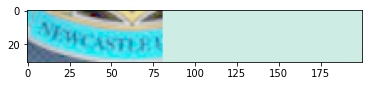

In [5]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)


Now we can run training.

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/1000
356/356 [==============================] - ETA: 0s - loss: 2.9193105 / 714 instances have illegal characters.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


356/356 [==============================] - 112s 229ms/step - loss: 2.9193 - val_loss: 2.2530
Epoch 2/1000
356/356 [==============================] - 79s 222ms/step - loss: 2.2230 - val_loss: 2.1934
Epoch 3/1000
356/356 [==============================] - 79s 222ms/step - loss: 1.8145 - val_loss: 1.9122
Epoch 4/1000
356/356 [==============================] - 79s 221ms/step - loss: 1.5220 - val_loss: 1.7340
Epoch 5/1000
356/356 [==============================] - 79s 221ms/step - loss: 1.2948 - val_loss: 2.1731
Epoch 6/1000
356/356 [==============================] - 78s 220ms/step - loss: 1.0527 - val_loss: 2.0525
Epoch 7/1000
356/356 [==============================] - 78s 220ms/step - loss: 1.0442 - val_loss: 1.7723
Epoch 8/1000
356/356 [==============================] - 78s 220ms/step - loss: 0.9093 - val_loss: 1.9979
Epoch 9/1000
356/356 [==============================] - 78s 220ms/step - loss: 0.7583 - val_loss: 2.0192
Epoch 10/1000
356/356 [==============================] - 78s 220ms/

Finally, run inference on a test sample.

Predicted: today, Actual: today


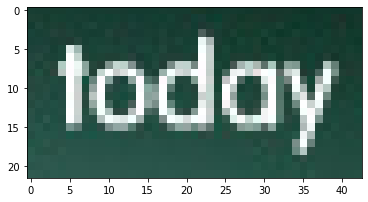

In [7]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))